# Topic Model Tuning

In this tutorial, we will tune a topic model on a synthetic RNA-seq dataset to demonstrate the optimization functionalities. To get started, one must have a matrix of raw counts (UMI-collpased for scRNA-seq). **MIRA assumes you have already completed QC and cell filtering**. Feeding low-quality cells into a MIRA topic will decrease the quality of the topics and latent embeddings.

First, import some packages:

In [50]:
import mira
import scanpy as sc
import numpy as np
mira.utils.pretty_sderr()

In [51]:
data = sc.read_h5ad('data/test_synth_differentiation.h5ad')
data

AnnData object with n_obs × n_vars = 1000 × 18023
    obs: 'mix_weight_0', 'mix_weight_1', 'mix_weight_2', 'mix_weight_3', 'is_end_cell', 'is_start_cell'
    var: 'feature_type'
    layers: 'counts'

In [52]:
data.raw = data

sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, min_disp=0.2)

data.var['exog'] = data.var.highly_variable
data.var['endog'] = data.var.highly_variable & (data.var.dispersions_norm > 0.7)

data.var.endog.sum(), data.var.exog.sum()

(2810, 5638)

In [54]:
data.layers['counts'] = data.raw.to_adata().X.copy()

data = data[np.random.permutation(len(data))]

In [73]:
model = mira.topics.ExpressionTopicModel(
    exogenous_key = 'exog', 
    endogenous_key = 'endog',
    counts_layer = 'counts',
)

In [74]:
model.get_learning_rate_bounds(data, eval_every=1)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog


Learning rate range test:   0%|          | 0/94 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (0.0022226242762333343, 0.2931996902997328)


(0.0022226242762333343, 0.2931996902997328)

INFO:mira.topic_model.base:Set learning rates to: (0.01642309546393324, 0.2931996902997328)


<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

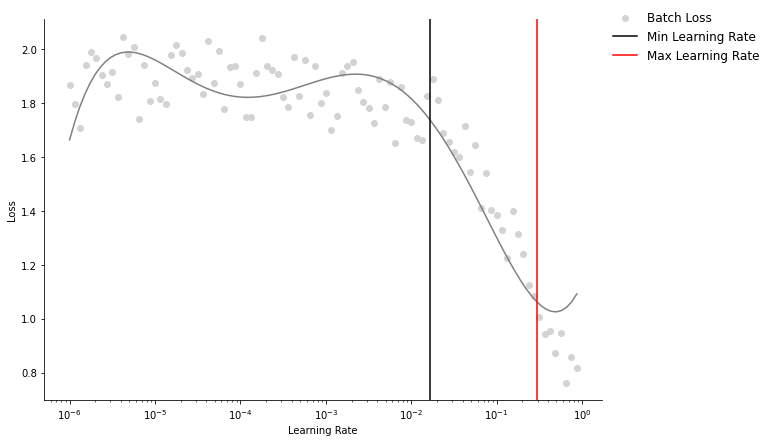

In [78]:
model.trim_learning_rate_bounds(2,0.5)
model.plot_learning_rate_bounds()

In [85]:
tuner = mira.topics.TopicModelTuner(model, save_name='data/example_model.pkl',
                                   seed=0, iters=32)

In [86]:
tuner.train_test_split(data)

INFO:mira.adata_interface.topic_model:Added col: test_set
INFO:mira.adata_interface.core:Added cols to obs: test_set


In [84]:
tuner.tune(data)

AttributeError: 'TopicModelTuner' object has no attribute 'get_pruner'